# WatchYourStep with StellarGraph

- dataset: local Cora

## start with node-classification

In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks, regularizers

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

### graph setting

In [2]:
# set edges
edges = pd.read_table('../datasets/cora/cora.cites', header=None)
edges.columns = ['source', 'target'] # should be follow this column name
gx = nx.from_pandas_edgelist(edges) # stellar graph form

# load features
features = pd.read_table('../datasets/cora/cora.content', header=None, index_col=0)
target = pd.DataFrame(features[features.columns[-1]].values, index=features.index)
features = features.drop(features.columns[-1], axis=1)
col_names = ['w_'+str(i) for i in range(1, 1434)]
features.columns = col_names


# make graph
G = sg.StellarGraph(gx, node_features=features)
nodes = list(G.nodes())
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
    Features: float32 vector, length 1433
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]


### node generator
- WYS is adjacency model

In [3]:
from stellargraph.mapper import AdjacencyPowerGenerator

# it can be run fast via SVD
generator = AdjacencyPowerGenerator(G)


In [4]:
# just flow(not split)
batch_size = 8
flow = generator.flow(batch_size=batch_size)

### build implemented model

In [5]:
from stellargraph.layer import WatchYourStep

wys = WatchYourStep(generator=generator, embedding_dimension=128, attention_regularizer=regularizers.l2(0.5)) # use l2 norm regularization
nc_inp, nc_out = wys.build()
nc_model = Model(inputs=nc_inp, outputs=nc_out)


### inject a few layer(FC) to better do ML things

In [6]:
from stellargraph.losses import graph_log_likelihood
# use special graph_loss
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=graph_log_likelihood,
)

In [7]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='loss')
nc_hist = nc_model.fit(flow, epochs=200,
                       steps_per_epoch=int(len(G.nodes()))//batch_size, # unless inf loops and does not train at all
                        callbacks=[es],
                        verbose=0)  

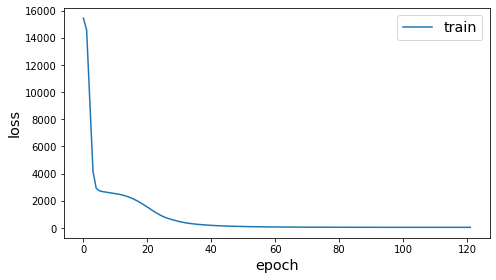

In [8]:
sg.utils.plot_history(nc_hist)

In [9]:
embeddings = wys.embeddings()

In [10]:
nodelist = list(G.nodes())

target = target.loc[nodelist]
# labels = preprocessing.OneHotEncoder(sparse=False).fit_transform(labels.values.reshape(-1, 1))


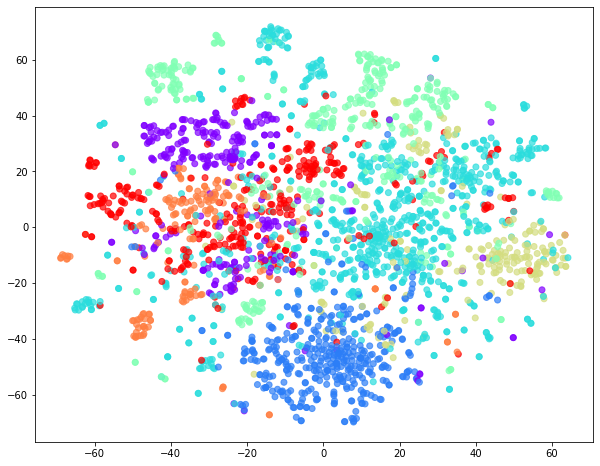

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(embeddings)

lbe = preprocessing.LabelEncoder()
col = lbe.fit_transform(target)

alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    cmap="rainbow",
    c=col,
    alpha=alpha,
)

In [12]:
lbe = preprocessing.LabelBinarizer()
targets = lbe.fit_transform(target)

# choose a random set of training nodes by permuting the labels and taking the first 300.
shuffled_idx = np.random.permutation(targets.shape[0])
train_node_idx = shuffled_idx[:500]
test_node_idx = shuffled_idx[500:]

training_labels = targets.copy()
training_labels[test_node_idx] = 0

In [13]:
d = embeddings.shape[1] // 2

predictions = np.dot(np.exp(np.dot(embeddings[:, :d], embeddings[:, d:].transpose())), training_labels)

np.mean(np.argmax(predictions[test_node_idx], 1) == np.argmax(targets[test_node_idx], 1))


0.7545289855072463

In [14]:
# Retrieve node embeddings and corresponding subjects
node_ids = list(G.nodes())  # list of node IDs
x = embeddings.copy()
y = target.copy()

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500)

print('fl-micro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_micro', cv=10)), 3))
print('f1-macro:', round(np.mean(model_selection.cross_val_score(lr, x, y, scoring='f1_macro', cv=10)), 3))


fl-micro: 0.7
f1-macro: 0.688
